# Linear regression

In [1]:
using DynamicHMCModels, MCMCChain

ProjDir = rel_path_d("..", "scripts", "05")
cd(ProjDir)

Import the dataset.

### snippet 5.1

In [2]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';')
df = convert(DataFrame, wd);
mean_ma = mean(df[:MedianAgeMarriage])
df[:MedianAgeMarriage_s] = convert(Vector{Float64},
  (df[:MedianAgeMarriage]) .- mean_ma)/std(df[:MedianAgeMarriage]);
# Show the first six rows of the dataset.
first(df, 6)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s
,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.60629
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0,-0.686699
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0,-0.204241
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5,1.22,41,1,111115,435450,0.26,-1.41039
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.0,0.599857
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.0,-0.284651


Model ``y ∼ Normal(y - Xβ, σ)``. Flat prior for `β`, half-T for `σ`.

In [3]:
struct WaffleDivorceProblem{TY <: AbstractVector, TX <: AbstractMatrix}
    "Observations."
    y::TY
    "Covariates"
    X::TX
end

Make the type callable with the parameters *as a single argument*.

In [4]:
function (problem::WaffleDivorceProblem)(θ)
    @unpack y, X, = problem   # extract the data
    @unpack β, σ = θ            # works on the named tuple too
    ll = 0.0
    ll += logpdf(Normal(10, 10), X[1]) # a = X[1]
    ll += logpdf(Normal(0, 1), X[2]) # b1 = X[2]
    ll += logpdf(TDist(1.0), σ)
    ll += loglikelihood(Normal(0, σ), y .- X*β)
    ll
end

Instantiate the model with data and inits.

In [5]:
N = size(df, 1)
X = hcat(ones(N), df[:MedianAgeMarriage_s]);
y = convert(Vector{Float64}, df[:Divorce])
p = WaffleDivorceProblem(y, X);
p((β = [1.0, 2.0], σ = 1.0))

-2225.6614871340917

Write a function to return properly dimensioned transformation.

In [6]:
problem_transformation(p::WaffleDivorceProblem) =
    as((β = as(Array, size(p.X, 2)), σ = asℝ₊))
# Wrap the problem with a transformation, then use Flux for the gradient.
P = TransformedLogDensity(problem_transformation(p), p)
∇P = LogDensityRejectErrors(ADgradient(:ForwardDiff, P));

Create an array to hold 1000 samples of 3 parameters in 4 chains

In [7]:
a3d = create_a3d(1000, 3, 4);
trans = as( (β = as(Array, 2), σ = asℝ₊ ));

Sample from the 4 chains and store the draws in the a3d array

In [8]:
mat = Array{Float64, 2}(undef, 1000, 3)
for j in 1:4
  chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
  posterior = TransformVariables.transform.(Ref(problem_transformation(p)),
    get_position.(chain));
  for l in 1:1000
    mat[l,:] = [posterior[l][1][1], posterior[l][1][2], posterior[l][2][1]]
  end
  insert_chain!(a3d, j, mat)
end

MCMC, adapting ϵ (75 steps)
3.1e-5 s/step ...done
MCMC, adapting ϵ (25 steps)
3.4e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
3.2e-5 s/step ...done
MCMC, adapting ϵ (100 steps)
2.7e-5 s/step ...done
MCMC, adapting ϵ (200 steps)
8.2e-5 s/step ...done
MCMC, adapting ϵ (400 steps)
2.4e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
2.8e-5 s/step ...done
MCMC (1000 steps)
4.0e-5 s/step ...done
MCMC, adapting ϵ (75 steps)
3.7e-5 s/step ...done
MCMC, adapting ϵ (25 steps)
5.5e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
3.4e-5 s/step ...done
MCMC, adapting ϵ (100 steps)
8.2e-5 s/step ...done
MCMC, adapting ϵ (200 steps)
3.0e-5 s/step ...done
MCMC, adapting ϵ (400 steps)
2.4e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
0.00013 s/step ...done
MCMC (1000 steps)
3.5e-5 s/step ...done
MCMC, adapting ϵ (75 steps)
4.7e-5 s/step ...done
MCMC, adapting ϵ (25 steps)
3.0e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
0.00012 s/step ...done
MCMC, adapting ϵ (100 steps)
3.0e-5 s/step ...done
MCMC, adapt

Convert to a MCMCChain

In [9]:
chns = create_mcmcchain(a3d, ["a", "bA", "σ"]);

cmdstan result

In [10]:
cmdstan_result = "
Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
    a  9.6882466 0.22179190 0.0035068378 0.0031243061 1000
   bA -1.0361742 0.21650514 0.0034232469 0.0034433245 1000
sigma  1.5180337 0.15992781 0.0025286807 0.0026279593 1000

Quantiles:
         2.5%      25.0%     50.0%      75.0%       97.5%
    a  9.253141  9.5393175  9.689585  9.84221500 10.11121000
   bA -1.454571 -1.1821025 -1.033065 -0.89366925 -0.61711705
sigma  1.241496  1.4079225  1.504790  1.61630750  1.86642750
";

Extract the parameter posterior means: `β`,

In [11]:
describe(chns)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
      Mean        SD       Naive SE       MCSE      ESS
 a  9.6853097 0.20713013 0.0032750150 0.0037280590 1000
bA -1.0894651 0.21726773 0.0034353044 0.0037767820 1000
 σ  1.4947478 0.15608481 0.0024679175 0.0028464925 1000

Quantiles:
      2.5%       25.0%      50.0%      75.0%      97.5%   
 a  9.2671619  9.5503521  9.6844772  9.8178147 10.09993596
bA -1.5209628 -1.2334415 -1.0916867 -0.9427870 -0.66404443
 σ  1.2264125  1.3848506  1.4826321  1.5904771  1.83803774



Plot the chains

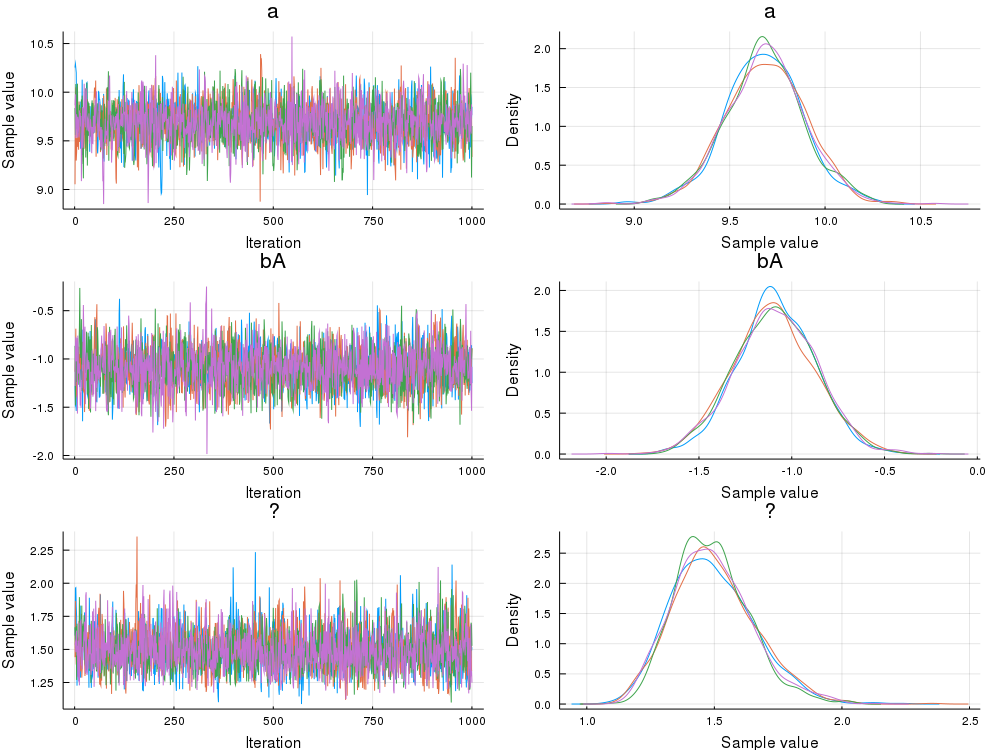

In [12]:
plot(chns)

end of m4.5d.jl#-
*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*